# <span style='color:Blue;align:center'><center>Pune Air Quality Index Analysis</center></span>
### <span style='color:Orange'>Does air quality index worsen during festival season?</span>
<i>Note : Pune Municipal Corporation cannot warrant the quality or accuracy of the data.</i>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as plt_dates 
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

<a id="main"></a>
<div class="alert alert-block alert-success">
    <h2>Index</h2>
</div>

1. [Explore Data](#1.dataexplore)
2. [Time Series Plotter Function](#2.plot)
3. [Exponentially Weighted Moving Averages](#3.ewma)
4. [Data imputation](#4.imputation)

<a id="1.dataexplore"></a>

<div class="alert alert-block alert-info">
    <h2>Explore Data</h2>
</div>

In [2]:
#check list of files
!ls

Air Quality Parameters - MPCB (2006-08).xlsx
Air Quality Parameters - MPCB (2009-11).xlsx
Air Quality Parameters - MPCB (2012-14).xlsx
Air Quality Parameters - MPCB (2015-17).xlsx
Air Quality Parameters - MPCB (2018-19 March).xlsx
Air_Quality_Index_Analysis.ipynb
airpollution_data_cleaning.ipynb
clean_bhosari_all.csv
clean_karvenagar_all.csv
clean_ns_all.csv
clean_pcmc_all.csv
clean_pimpri_all.csv
clean_swargate_all.csv
cleaned.csv
dates
dates.csv
library_functions.ipynb


In [3]:
#Read the karve road file and make 'date' column as the index of DataFrame
df_karveroad = pd.read_csv('clean_karvenagar_all.csv',parse_dates=['date'],index_col=1)

In [4]:
df_karveroad.head()

,Unnamed: 0,so2,nox,rspm,spm,co2,aqi,location
date,,,,,,,,
2007-06-19,0,6,46,49,0,0,58,Karve Road
2007-06-20,1,6,43,29,0,0,54,Karve Road
2007-06-21,2,5,43,26,0,0,54,Karve Road
2007-06-23,3,7,46,79,0,0,79,Karve Road
2007-06-24,4,5,45,19,0,0,56,Karve Road


In [5]:
df_karveroad.drop(['Unnamed: 0'],inplace=True,axis=1) # drop the old index column from CSV

In [6]:
df_karveroad.head()

,so2,nox,rspm,spm,co2,aqi,location
date,,,,,,,
2007-06-19,6,46,49,0,0,58,Karve Road
2007-06-20,6,43,29,0,0,54,Karve Road
2007-06-21,5,43,26,0,0,54,Karve Road
2007-06-23,7,46,79,0,0,79,Karve Road
2007-06-24,5,45,19,0,0,56,Karve Road


In [7]:
df_karveroad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3894 entries, 2007-06-19 to 2019-03-24
Data columns (total 7 columns):
so2         3894 non-null int64
nox         3894 non-null int64
rspm        3894 non-null int64
spm         3894 non-null int64
co2         3894 non-null int64
aqi         3894 non-null int64
location    3894 non-null object
dtypes: int64(6), object(1)
memory usage: 243.4+ KB


#### The data present for AQI is not for all the days and is around 403 dates are missing

In [8]:
#Get all dates in the date range
date_index=pd.date_range(df_karveroad.index.min(),df_karveroad.index.max())

In [9]:
# Add missing dates to dataframe
df_kr = df_karveroad.reindex(date_index)

In [10]:
# Add location to Karve Road for newly added dates
df_kr.loc[df_kr['location'] != 'Karve Road'.index,['location']] = 'Karve Road'

In [11]:
df_kr.head()

,so2,nox,rspm,spm,co2,aqi,location
2007-06-19,6.0,46.0,49.0,0.0,0.0,58.0,Karve Road
2007-06-20,6.0,43.0,29.0,0.0,0.0,54.0,Karve Road
2007-06-21,5.0,43.0,26.0,0.0,0.0,54.0,Karve Road
2007-06-22,NaN,NaN,NaN,NaN,NaN,NaN,Karve Road
2007-06-23,7.0,46.0,79.0,0.0,0.0,79.0,Karve Road


In [12]:
# Replace 0 values in the aqi with nan so that these can be imputed using fillna function
df_kr.loc[df_kr[df_kr['aqi']==0].index,['aqi']] = np.nan

<a id="2.plot"></a>

<div class="alert alert-block alert-info">
    <h2>Timeseries plotter function</h2>
</div>

[go back to index](#main)

In [76]:
plt.style.use('seaborn')

In [77]:
def timesearies_plotter(x,y,title="",fig=None,ax=None,color='blue',
                        x_locator=30,date_format='%d-%b-%Y',xlim=[],ylim=[],
                        label='',
                        xlabel='',
                        ylabel=''
                       ):
    '''
    Plots time series using matplotlib
    '''
    
    date_formatter = plt_dates.DateFormatter(date_format)
    if fig is None and ax is None:
        fig, ax = plt.subplots(1,figsize=(20,15))
    
    
    line = ax.plot(x,y,color=color,label=label,linewidth=2)
    ax.legend(prop={'size':20})
    ax.xaxis.set_major_formatter(date_formatter)
    ax.xaxis.set_major_locator(plt_dates.DayLocator(interval=x_locator))
    fig.autofmt_xdate()
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if title:
        ax.set_title(title,fontsize=32,fontweight='bold')
    if xlabel:
        ax.set_xlabel(xlabel,fontsize=20,fontweight='bold')
    if ylabel:
        ax.set_ylabel(ylabel,fontsize=20,fontweight='bold')
    ax.autoscale_view()
    ax.tick_params(axis='both',which='major',labelsize='16')
    ax.grid(True)
    fig.tight_layout()
    return fig, ax

<a id="3.ewma"></a>

<div class="alert alert-block alert-info">
    <h2> Exponentially Weighted Moving Average </h2>
</div>

[go back to index](#main)

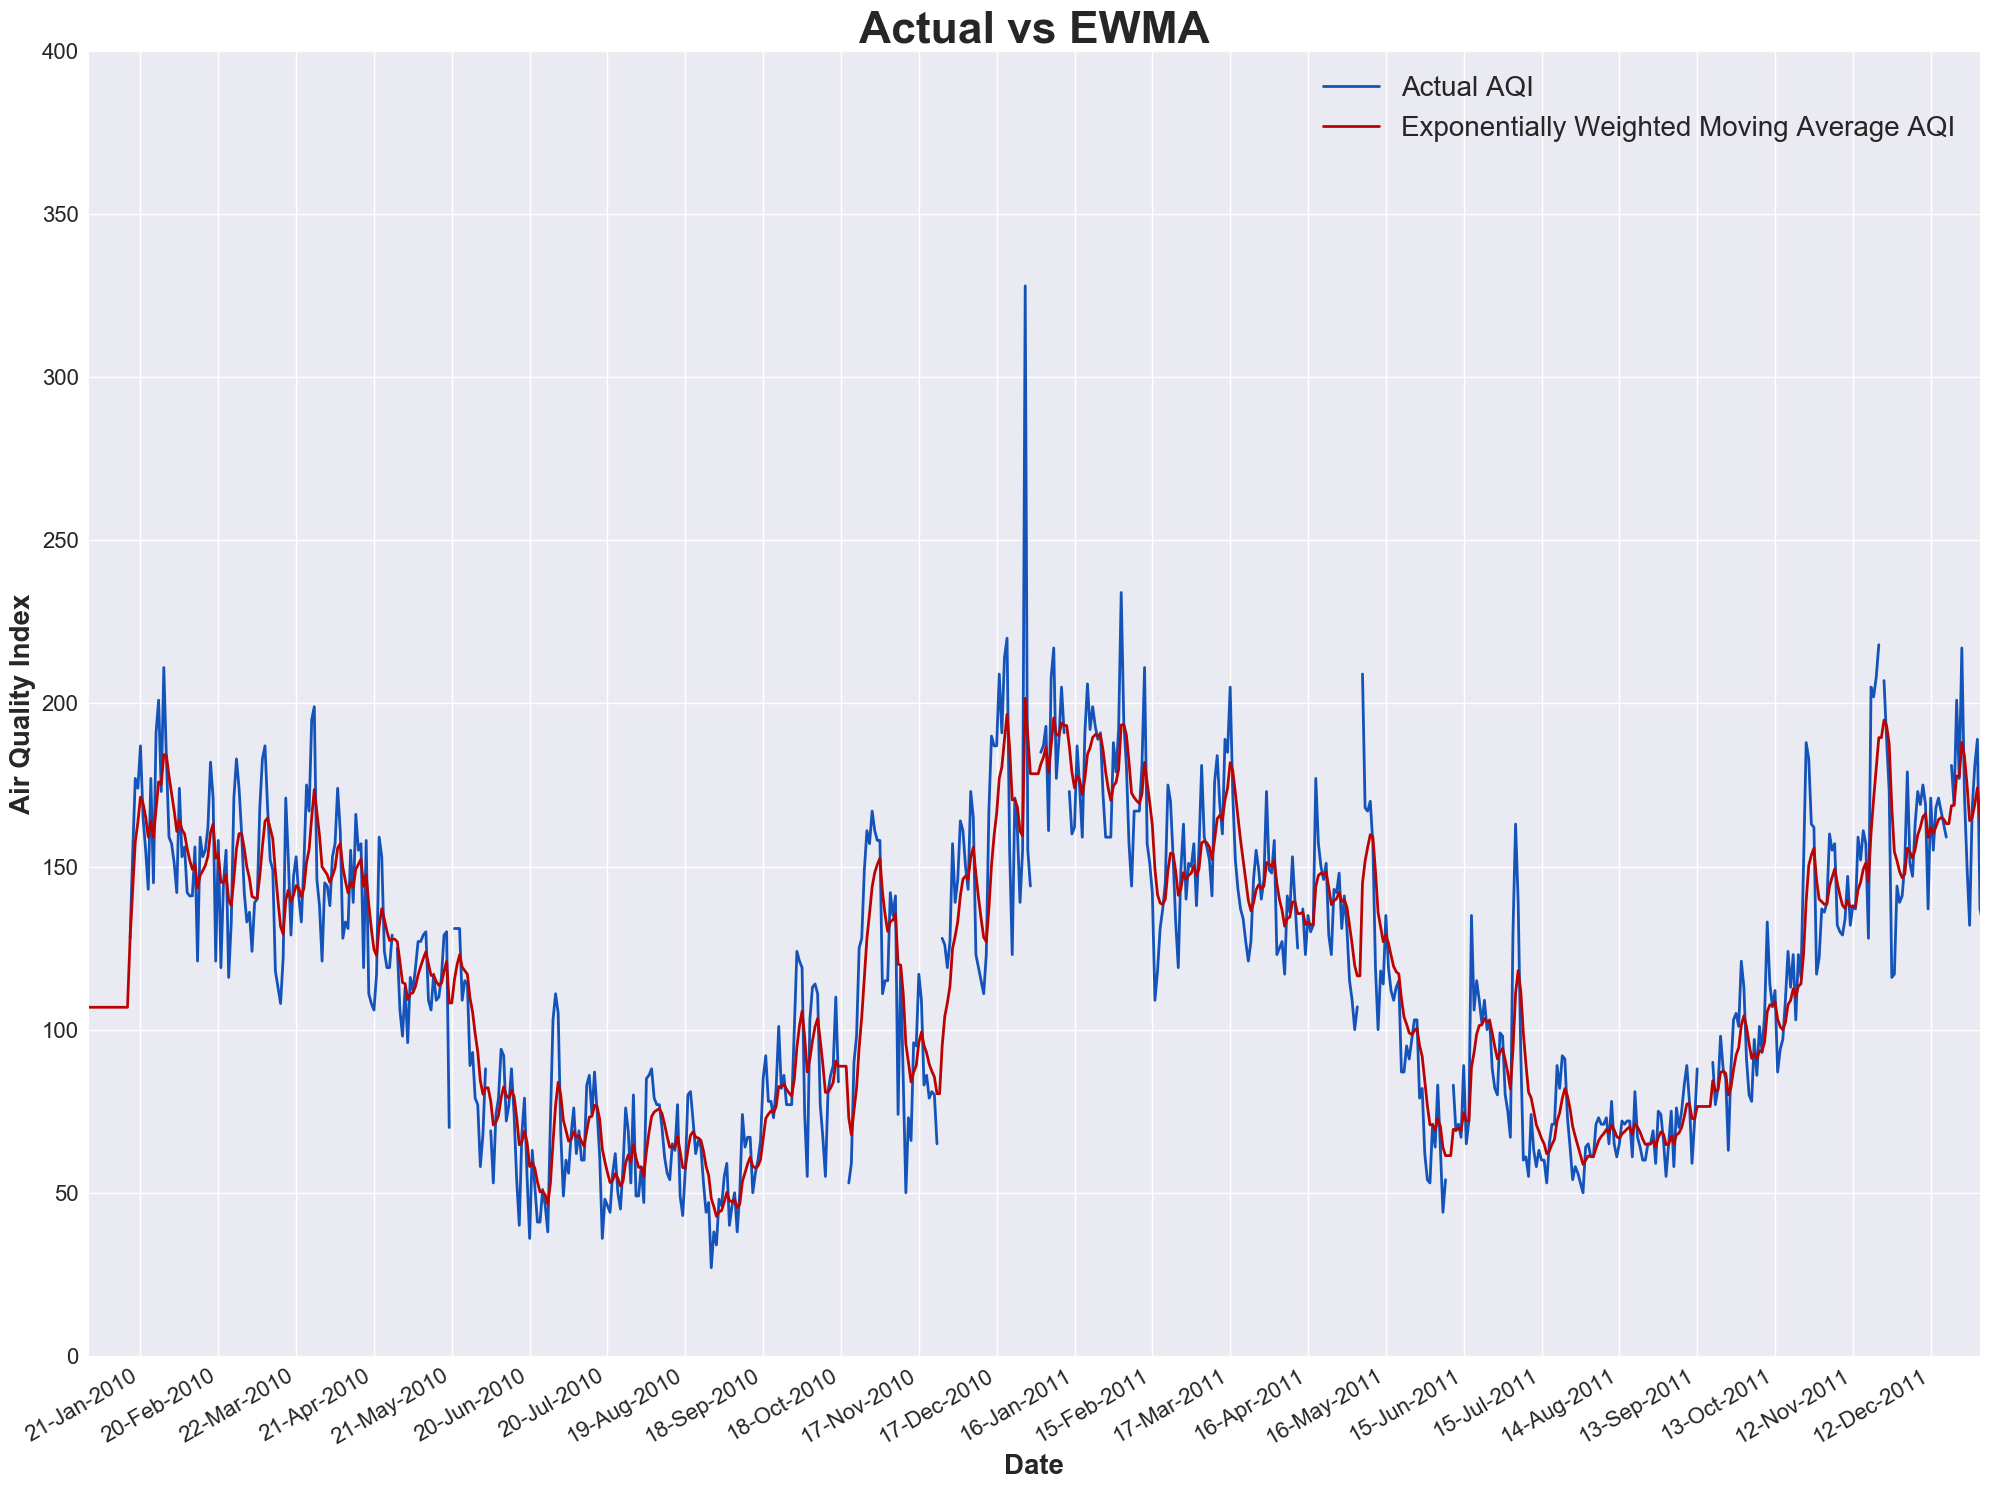

In [78]:
# calculate Exponentially weighted Moving Average with span of 5 days
ewma_kr = df_kr['aqi'].ewm(span=7).mean()
# Plot actual AQI vs EWMA of AQI
fig, ax = timesearies_plotter(df_kr.index,df_kr['aqi'],
                              title='Actual vs EWMA',
                              xlim=['2010-01-01','2011-12-31'],
                              ylim=[0,400],
                              label='Actual AQI',
                              xlabel='Date',
                              ylabel='Air Quality Index',
                              color='#1353ba'
                             )
_ = timesearies_plotter(ewma_kr.index,
                        ewma_kr,
                        fig=fig,ax=ax,
                        color='#ba0404',
                        label='Exponentially Weighted Moving Average AQI'
                        )

<a id="4.imputation"></a>
<div class="alert alert-block alert-info">
    <h2>Impute Missing Values</h2>
</div>

[go back to index](#main)

In [18]:
#get difference between ewma and actual value. Drop the ones which has nan
resd = (df_kr['aqi']- ewma_kr).dropna()

In [19]:
# to maintain random error in the missing value replacement, Get randomg samples from residual error
# and then choose residual randomly and then add in ewma_kr
# we will use this ewma which includes randomness in error as per other samples
interim_data = ewma_kr + np.random.choice(resd,len(ewma_kr))

In [20]:
df_kar_new = df_kr['aqi'].fillna(interim_data)

In [21]:
len(df_kr['aqi'])

4297

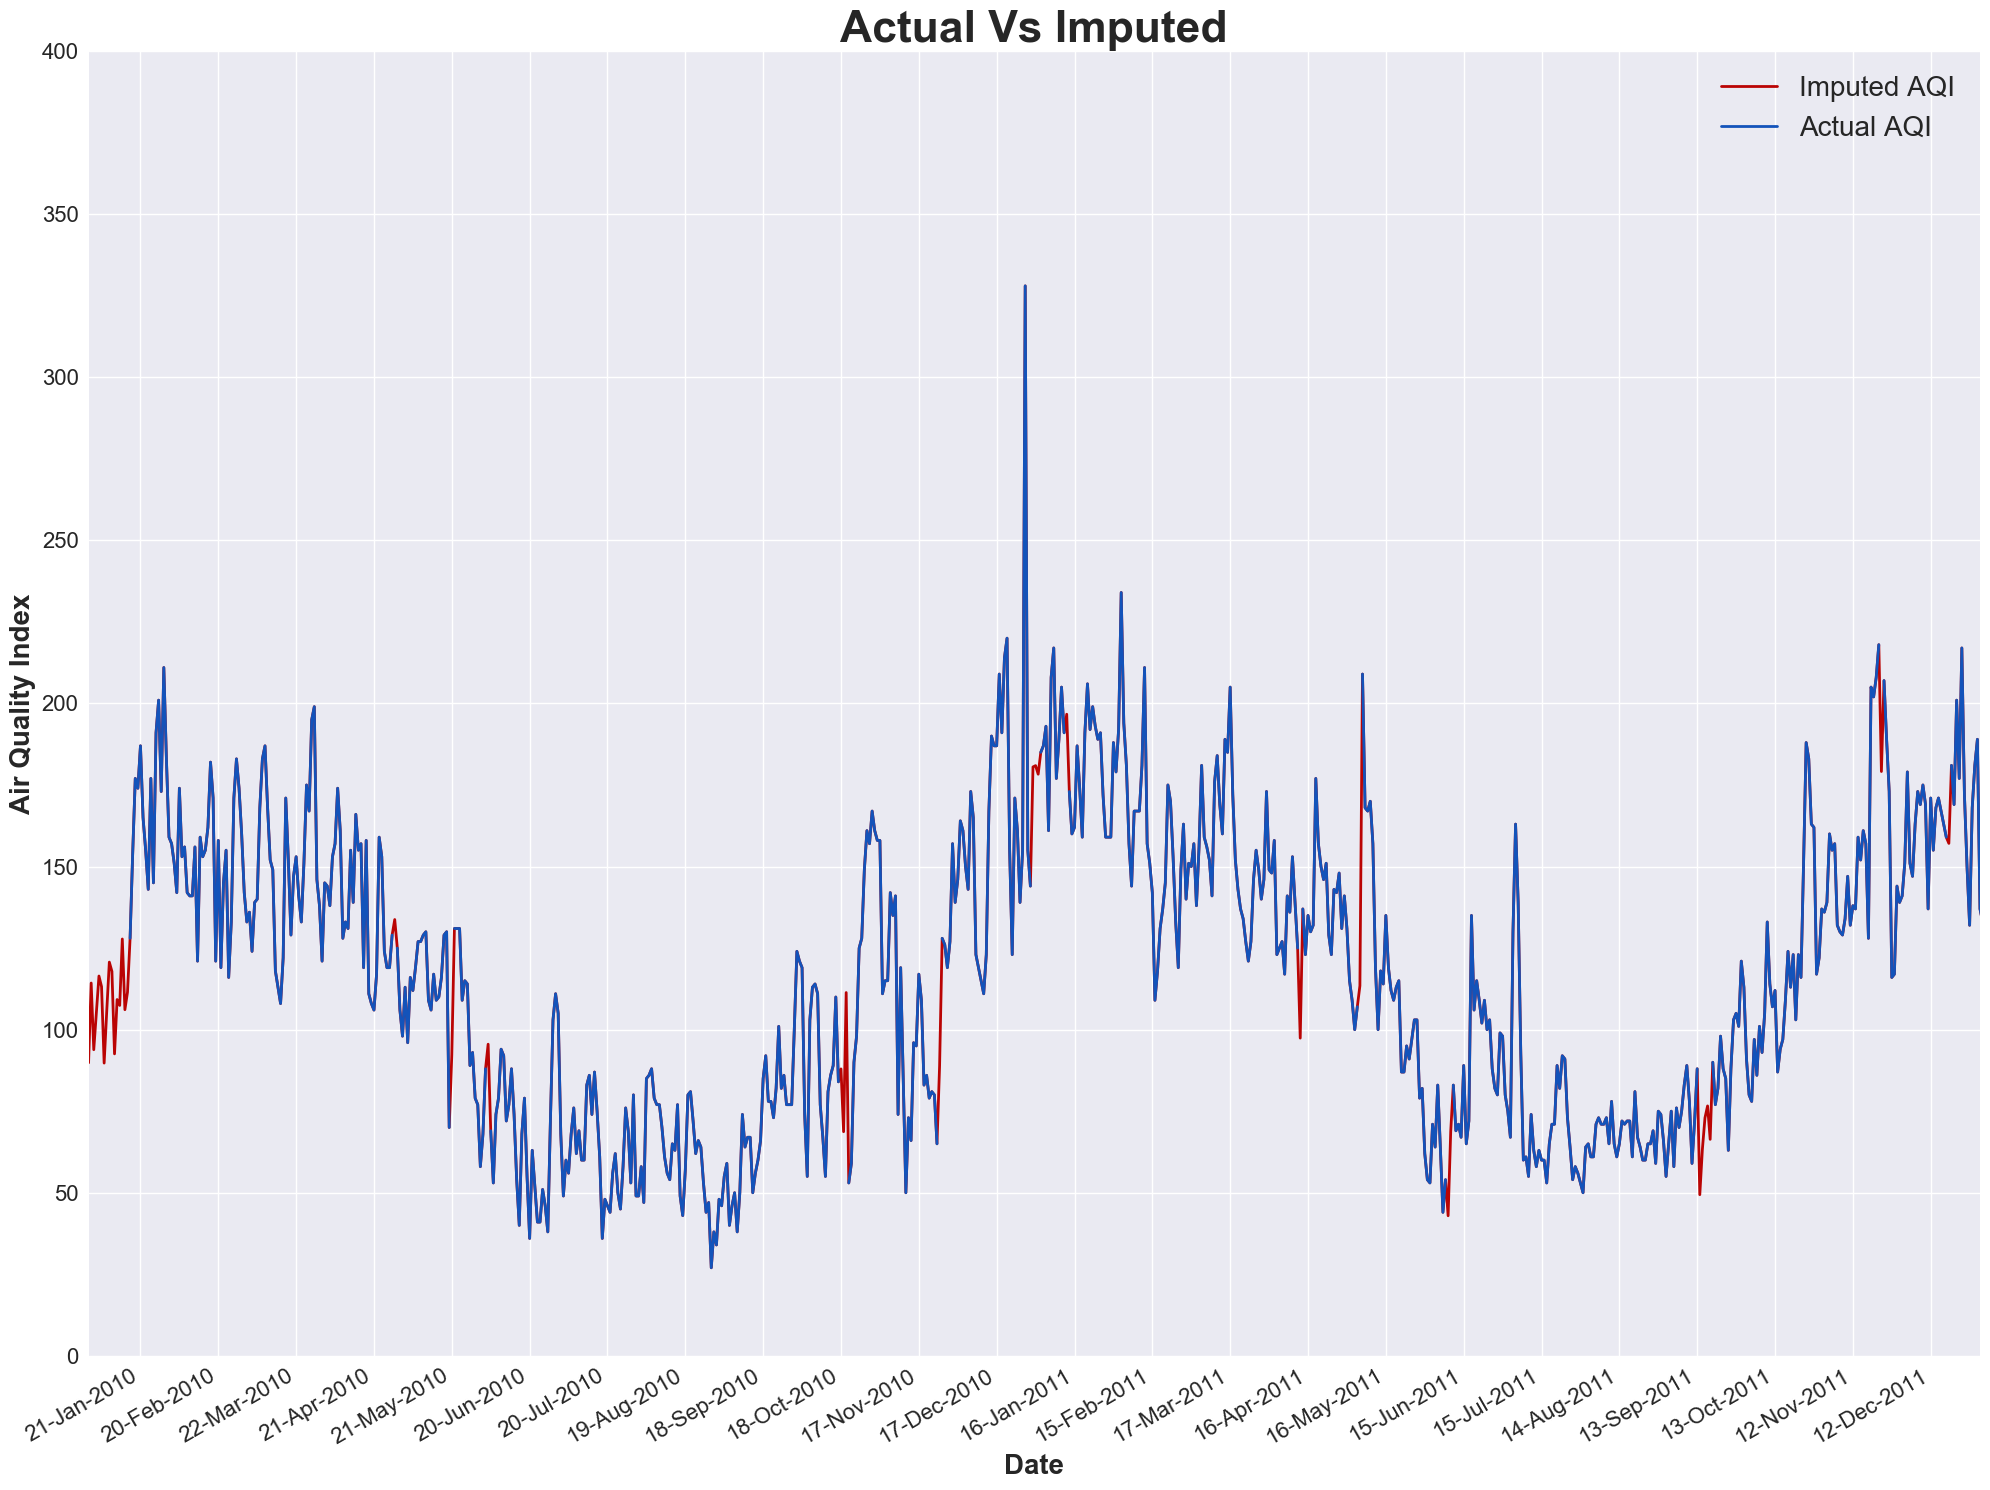

In [79]:
fig, ax = timesearies_plotter(df_kr.index,
                        df_kar_new,
                        color='#ba0404',
                        xlim=['2010-01-01','2011-12-31'],
                        ylim=[0,400],
                        title='Actual Vs Imputed',
                        label='Imputed AQI',
                        ylabel='Air Quality Index',
                        xlabel='Date'
                       )
_ = timesearies_plotter(df_kr.index,df_kr['aqi'],fig=fig,ax=ax,
                        label="Actual AQI",color='#1353ba')

In [81]:
#plt.style.available #to read available matplotlib styles